In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Estadística e Inferencia I/DFs/turbines.csv"

Mounted at /content/drive


In [ ]:
df = pd.read_csv(path)
df.columns = ['Hours', 'Proportions of Fissures']
n = len(df)

(-0.1, 1.0)

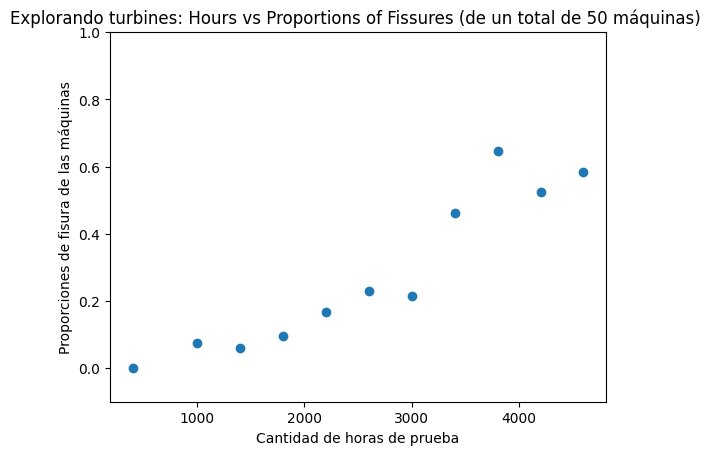

In [ ]:
#a)
fig, ax = plt.subplots()
ax.scatter(df["Hours"],df["Proportions of Fissures"])
ax.set_xlabel("Cantidad de horas de prueba")
ax.set_ylabel("Proporciones de fisura de las máquinas")
ax.set_title("Explorando turbines: Hours vs Proportions of Fissures (de un total de 50 máquinas) ")
ax.set_ylim(-0.1,1)

-  Como la respuesta del problema viene dada en proporciones de máquinas con fisuras durante las pruebas, es decir, los valores de $Y$ están entre 0 y 1. Por lo tanto, la elección de un GLM Binomial es una opción razonable para modelar la dependencia de la fracción de tiburas con fisuras respecto a la cantidad de horas.

 $$ \Large \Rightarrow f(y;p,n) =  {n \choose ny} p^{ny}(1-p)^{n-ny} = {n \choose ny} e^{ \frac{y\ln(\frac{p}{1 - p}) - (-\ln(p))}{\frac {1}{n}}} $$

$$ a(y,n) =  {n \choose ny} $$ \\
$$ \phi = \frac{1}{n} $$ \\
$$ \theta = ln(\frac{p}{1-p})$$ \\
$$ \kappa(\theta) =  ln(1 - e^{\theta})$$ \\

- Función de vínculo
$$ \boxed {\eta = ln(\frac{p}{1-p}) = \beta_{0} +\beta_{1}X} $$

La likelihood es $$ \Large \mathcal{L}(p) = \prod_{i=1}^n a(y) e^{\frac{y_i\ln(\frac{p}{1-p})- ( -\ln(1-p))}{\frac{1}{n}}} = \prod_{i=1}^n a(y) e^{n(y_i\ln(\frac{p}{1-p})+\ln(1-p))}  $$

donde $ \large p = p(\beta_0,\beta_1) = \frac{e^{\beta_0 + \beta_1x_i}}{1 + e^{\beta_0 + \beta_1x_i}}$. Entonces maximizar $\mathcal{L}(p)$ es lo mismo que minimizar $-\log(\mathcal{L}(p) $ y eso es lo que hago en el código.

In [ ]:
#b)
def neg_log_likelihood_binomial(beta, X, Y):
    p = np.exp(np.dot(X, beta)) / ( 1 + np.exp(np.dot(X, beta))) #función de vínculo
    return -n * np.sum( Y * np.log(p /(1-p)) + np.log(1 - p) )

<ipython-input-5-6fb2822edff0>:4: RuntimeWarning: divide by zero encountered in log
  return -n * np.sum( Y * np.log(p /(1-p)) + np.log(1 - p) )
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
<ipython-input-5-6fb2822edff0>:4: RuntimeWarning: divide by zero encountered in log
  return -n * np.sum( Y * np.log(p /(1-p)) + np.log(1 - p) )


b0 =  -3.9110383846501606
b1 =  0.001011005312435445


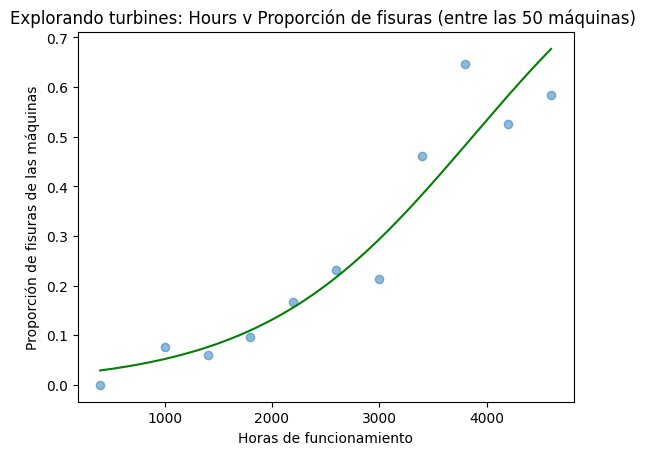

In [ ]:
from scipy.optimize import minimize

X,Y = df["Hours"], df["Proportions of Fissures"]

intercept = np.ones(X.shape)
X_with_intercept = np.column_stack((intercept,X))

initial_beta = np.zeros(X_with_intercept.shape[1])
res_binomial = minimize(neg_log_likelihood_binomial, initial_beta, args=(X_with_intercept, Y))

b0 = res_binomial.x[0]
b1 = res_binomial.x[1]

print('b0 = ', b0)
print('b1 = ', b1)

x_range = np.linspace(X.min(), X.max(), 300)
binomial_fit = np.exp(b0 + b1 * x_range) / (1 + np.exp(b0 + b1 * x_range))

fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x_range,binomial_fit,color='g')
ax.set_xlabel("Horas de funcionamiento")
ax.set_ylabel("Proporción de fisuras de las máquinas")
ax.set_title("Explorando turbines: Hours v Proporción de fisuras (entre las 50 máquinas) ")
plt.show()

Para esto necesito obtener la matriz de Fischer de la distribución:

$$I = \frac{1}{\phi}X^TWX \hspace{1cm}\text{ con }W = \text{diag}(\frac{1}{V(p_i)(d\eta_i/dp_i)^2}) $$

En nuestro caso:
$$\phi = \frac{1}{n} $$

$$ V(p) = p(1-p) $$

$$ \frac{d\eta}{dp} = \frac{d(\ln(\frac{p}{1 - p}))}{dp} = \frac{1}{p(1-p)}$$

por lo tanto $$I = nX^TWX \hspace{1cm}W = \text{diag}(p_i) = \text{diag}(p_i(1-p_i)) $$

con $p = p(\beta_0,\beta_1) = \frac{e^{\beta_0 + \beta_1x_i}}{1+e^{\beta_0 + \beta_1x_i}}$

Finalmente, la matriz de covarianza es $I^{-1}$ y su diagonal, las varianzas respectivas de $\beta_0$ y $\beta_1$:

In [ ]:
#c)
from numpy.linalg import inv

phi = 1 / n
p = np.exp(X_with_intercept@res_binomial.x) / (1 + np.exp(X_with_intercept @ res_binomial.x))

W = np.diag( p * (1-p)  )

I = (1 / phi) * X_with_intercept.T @ W @ X_with_intercept

cov_matrix = inv(I)
cov_matrix

array([[ 5.59394552e-01, -1.57564727e-04],
       [-1.57564727e-04,  4.90629174e-08]])

In [ ]:
se_b0 = np.sqrt(cov_matrix[0,0])
se_b1 = np.sqrt(cov_matrix[1,1])
print("se(b0) =",se_b0)
print("se(b1) =",se_b1)

se(b0) = 0.7479268357935938
se(b1) = 0.00022150150653965333
